# Loading Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(12, 5)},
        font_scale=1.5,
        style="whitegrid")
        
from pyspark.sql import HiveContext
from pyspark.sql import SQLContext

# initialize session hive and sql environments
hiveContext = HiveContext(sc)
sqlContext = SQLContext(sc)

# Data Reading

In [3]:
project_folder = "../"
datapath = project_folder + "data/"
plotpath = project_folder + "graphs/"
mungepath = project_folder + "munge/"
configpath = project_folder + "config/"
diagnostic = project_folder + "diagnostic/"
modelpath = project_folder + "model/"
output = project_folder + "output/"

In [4]:
from pyspark.sql.functions import col

train = spark.read.csv(os.path.join(datapath,"train.csv"), header=True)
print('Found %d observations in training set.' %train.count())

Found 184903890 observations in training set.


In [5]:
from pyspark.sql.functions import col

test_old = (spark.read.csv(os.path.join(datapath,"test_supplement.csv"), header=True)
            .filter(col('click_time') >= '2017-11-09 16:00:00'))

print('Found %d observations in test_old set.' %test_old.count())

Found 57536872 observations in test_old set.


In [6]:
train.show(10)

+------+---+------+---+-------+-------------------+---------------+-------------+
|    ip|app|device| os|channel|         click_time|attributed_time|is_attributed|
+------+---+------+---+-------+-------------------+---------------+-------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|           null|            0|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|           null|            0|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|           null|            0|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|           null|            0|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|           null|            0|
| 18787|  3|     1| 16|    379|2017-11-06 14:36:26|           null|            0|
|103022|  3|     1| 23|    379|2017-11-06 14:37:44|           null|            0|
|114221|  3|     1| 19|    379|2017-11-06 14:37:59|           null|            0|
|165970|  3|     1| 13|    379|2017-11-06 14:38:10|           null|            0|
| 74544| 64|    

In [7]:
train.printSchema()

root
 |-- ip: string (nullable = true)
 |-- app: string (nullable = true)
 |-- device: string (nullable = true)
 |-- os: string (nullable = true)
 |-- channel: string (nullable = true)
 |-- click_time: string (nullable = true)
 |-- attributed_time: string (nullable = true)
 |-- is_attributed: string (nullable = true)



# Build the full dataset

In [8]:
# train and test set concatenation
from pyspark.sql.functions import col
data = (train.select('ip', 'app', 'device', 'os', 'channel', 'click_time')
        .unionAll(test_old.select('ip', 'app', 'device', 'os', 'channel', 'click_time')))
        
print('Total number of clicks in one week:', data.count())

Total number of clicks in one week: 242440762


In [9]:
data.show(5)

+------+---+------+---+-------+-------------------+
|    ip|app|device| os|channel|         click_time|
+------+---+------+---+-------+-------------------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08|
+------+---+------+---+-------+-------------------+
only showing top 5 rows



# Datetime Features

In [10]:
# day function
def get_day(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        day: A String containing the day of click ("06", "07", .."10")
    """
    
    return date[8:10]

# hour function
def get_hour(date):
    """
    Returns the hour based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the hour interval ("01", "02", .."23")
    """
    
    return date[11:13]

# minute function
def get_minute(date):
    """
    Returns the minute based on a string date
        
    Args:
        date (String): A String containing the click datetime

    Returns:
        hour: A String containing the minute interval ("01", "02", .."59")
    """
    
    return date[14:16]

In [11]:
# Get datetime features
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

day_udf = udf(get_day, StringType())
hour_udf = udf(get_hour, StringType())
minute_udf = udf(get_minute, StringType())

data = data.withColumn('day', day_udf(data.click_time))
data = data.withColumn('hour', hour_udf(data.click_time))
data = data.withColumn('minute', minute_udf(data.click_time))

In [12]:
data.show(5)

+------+---+------+---+-------+-------------------+---+----+------+
|    ip|app|device| os|channel|         click_time|day|hour|minute|
+------+---+------+---+-------+-------------------+---+----+------+
| 83230|  3|     1| 13|    379|2017-11-06 14:32:21| 06|  14|    32|
| 17357|  3|     1| 19|    379|2017-11-06 14:33:34| 06|  14|    33|
| 35810|  3|     1| 13|    379|2017-11-06 14:34:12| 06|  14|    34|
| 45745| 14|     1| 13|    478|2017-11-06 14:34:52| 06|  14|    34|
|161007|  3|     1| 13|    379|2017-11-06 14:35:08| 06|  14|    35|
+------+---+------+---+-------+-------------------+---+----+------+
only showing top 5 rows



# IP Number of Clicks for same OS

In [13]:
from pyspark.sql.functions import col, unix_timestamp, lit
import pyspark.sql.functions as func

In [14]:
var = 'os'

In [16]:
train.groupBy().agg(func.min('click_time')).show()

+-------------------+
|    min(click_time)|
+-------------------+
|2017-11-06 14:32:21|
+-------------------+



In [15]:
ip_var_clicks = (data
                 .withColumn('click_time_seconds',
                             (unix_timestamp(col('click_time')) - unix_timestamp(lit('2017-11-06 14:32:21'))))
                 .groupBy('ip', var)
                 .agg(func.count(func.lit(1)).alias('ip_'+var+'_clicks'),
                      func.round(func.stddev(col('click_time_seconds'))).alias('ip_'+var+'_std_click_time'),
                      func.round(func.stddev(col('hour')), 2).alias('ip_'+var+'_std_hour'),
                      func.round(func.stddev(col('minute')), 2).alias('ip_'+var+'_std_minute'),
                      func.round(func.mean(col('hour')), 2).alias('ip_'+var+'_avg_hour'),
                      func.round(func.mean(col('minute')), 2).alias('ip_'+var+'_avg_minute'))
                 .fillna({'ip_'+var+'_std_click_time':0,
                          'ip_'+var+'_std_hour':0,
                          'ip_'+var+'_std_minute':0,
                          'ip_'+var+'_avg_hour':0,
                          'ip_'+var+'_avg_minute':0})
                 .cache())

ip_var_clicks.show(100, truncate=False)

+------+---+------------+--------------------+--------------+----------------+--------------+----------------+
|ip    |os |ip_os_clicks|ip_os_std_click_time|ip_os_std_hour|ip_os_std_minute|ip_os_avg_hour|ip_os_avg_minute|
+------+---+------------+--------------------+--------------+----------------+--------------+----------------+
|59395 |19 |23982       |99425.0             |6.12          |17.49           |10.77         |29.35           |
|34036 |20 |260         |113006.0            |6.32          |17.34           |11.34         |24.28           |
|100275|13 |75167       |97937.0             |6.13          |17.45           |11.25         |29.54           |
|188653|41 |76          |11188.0             |8.66          |18.14           |13.39         |28.39           |
|139797|3  |24          |98925.0             |4.12          |21.65           |7.63          |29.88           |
|19188 |10 |509         |80565.0             |5.55          |17.88           |8.35          |26.98           |
|

In [19]:
data.filter((col('ip')==64779) & (col(var)==40)).show(truncate=False)

+-----+---+------+---+-------+-------------------+---+----+------+
|ip   |app|device|os |channel|click_time         |day|hour|minute|
+-----+---+------+---+-------+-------------------+---+----+------+
|64779|64 |1     |40 |459    |2017-11-06 16:00:25|06 |16  |00    |
|64779|6  |1     |40 |459    |2017-11-06 16:00:26|06 |16  |00    |
+-----+---+------+---+-------+-------------------+---+----+------+



## Export New Features

In [17]:
(ip_var_clicks
 .coalesce(1)
 .write
 .format("com.databricks.spark.csv")
 .option("header", "true")
 .mode("overwrite")
 .save(mungepath+"f_ip_"+var+"_clicks", compression="None"))

In [18]:
ip_var_clicks.count()

3578758

## Check the impact of new features

In [21]:
import pyspark.sql.functions as func

train.groupBy().agg(func.mean(col('is_attributed'))).show()

+--------------------+
|  avg(is_attributed)|
+--------------------+
|0.002470721410998979|
+--------------------+



In [20]:
train_sample = (train.sample(fraction=0.05, withReplacement=False, seed=22)
                .join(ip_var_clicks, ['ip', var], 'left_outer')
                .cache())

In [21]:
train_sample.count()

9248009

In [22]:
train.sample(fraction=0.05, withReplacement=False, seed=22).count()

9248009

In [23]:
train_sample.show(5, truncate=False)

+------+---+---+------+-------+-------------------+---------------+-------------+------------+--------------------+--------------+----------------+--------------+----------------+
|ip    |os |app|device|channel|click_time         |attributed_time|is_attributed|ip_os_clicks|ip_os_std_click_time|ip_os_std_hour|ip_os_std_minute|ip_os_avg_hour|ip_os_avg_minute|
+------+---+---+------+-------+-------------------+---------------+-------------+------------+--------------------+--------------+----------------+--------------+----------------+
|100032|13 |2  |1     |469    |2017-11-07 06:40:12|null           |0            |515         |103259.0            |6.3           |16.91           |8.72          |30.62           |
|100032|13 |7  |1     |101    |2017-11-07 10:27:59|null           |0            |515         |103259.0            |6.3           |16.91           |8.72          |30.62           |
|100032|13 |3  |1     |19     |2017-11-08 01:57:48|null           |0            |515         |103259

### ip_os_clicks

In [24]:
feature = 'ip_os_clicks'

In [25]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [26]:
PDF.head()

,is_attributed,ip_os_clicks
0,0,515
1,0,515
2,0,515
3,0,515
4,0,515


In [27]:
PDF_sorted = PDF.sort_values(by=feature)

In [28]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [29]:
PDF_sorted.head()

,is_attributed,ip_os_clicks,roll
5039953,0,1,NaN
191174,0,1,NaN
7243625,1,1,NaN
1693844,0,1,NaN
3402338,0,1,NaN


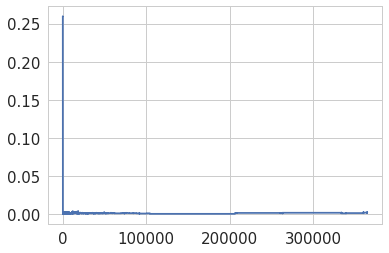

In [30]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

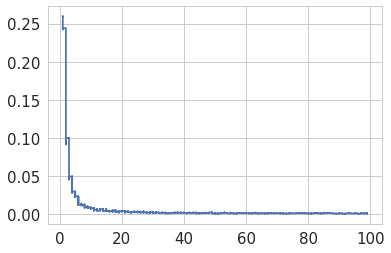

In [31]:
PDF_filtered = PDF_sorted[PDF_sorted[feature]<100]

plt.plot(PDF_filtered[feature], PDF_filtered.roll)

Very strong feature !

### ip_os_std_click_time

In [32]:
feature = 'ip_os_std_click_time'

In [33]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [34]:
PDF.head()

,is_attributed,ip_os_std_click_time
0,0,103259.0
1,0,103259.0
2,0,103259.0
3,0,103259.0
4,0,103259.0


In [35]:
PDF_sorted = PDF.sort_values(by=feature)

In [36]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [37]:
PDF_sorted.head()

,is_attributed,ip_os_std_click_time,roll
3343055,0,0.0,NaN
3921003,0,0.0,NaN
1325047,0,0.0,NaN
5464309,0,0.0,NaN
2333460,1,0.0,NaN


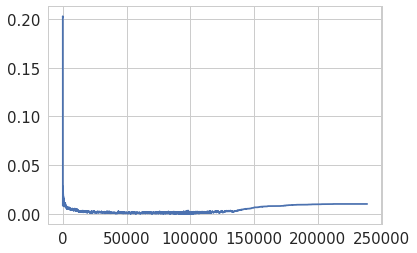

In [38]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

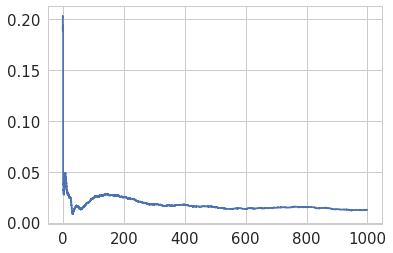

In [39]:
PDF_filtered = PDF_sorted[PDF_sorted[feature]<1000]

plt.plot(PDF_filtered[feature], PDF_filtered.roll)

Very strong feature !

### ip_os_std_hour

In [40]:
feature = 'ip_os_std_hour'

In [41]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [42]:
PDF.head()

,is_attributed,ip_os_std_hour
0,0,6.3
1,0,6.3
2,0,6.3
3,0,6.3
4,0,6.3


In [43]:
PDF_sorted = PDF.sort_values(by=feature)

In [44]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [45]:
PDF_sorted.head()

,is_attributed,ip_os_std_hour,roll
5063958,0,0.0,NaN
4664578,0,0.0,NaN
4664567,0,0.0,NaN
6551433,0,0.0,NaN
6551432,0,0.0,NaN


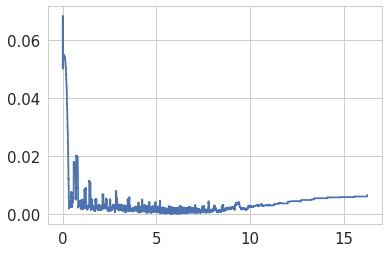

In [46]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !

### ip_os_std_minute

In [47]:
feature = 'ip_os_std_minute'

In [48]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [49]:
PDF.head()

,is_attributed,ip_os_std_minute
0,0,16.91
1,0,16.91
2,0,16.91
3,0,16.91
4,0,16.91


In [50]:
PDF_sorted = PDF.sort_values(by=feature)

In [51]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [52]:
PDF_sorted.head()

,is_attributed,ip_os_std_minute,roll
5738923,0,0.0,NaN
8874885,0,0.0,NaN
6001786,0,0.0,NaN
5070453,0,0.0,NaN
4614859,0,0.0,NaN


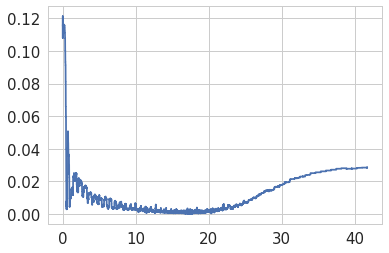

In [53]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !

### ip_os_avg_hour

In [54]:
feature = 'ip_os_avg_hour'

In [55]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [56]:
PDF.head()

,is_attributed,ip_os_avg_hour
0,0,8.72
1,0,8.72
2,0,8.72
3,0,8.72
4,0,8.72


In [57]:
PDF_sorted = PDF.sort_values(by=feature)

In [58]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [59]:
PDF_sorted.head()

,is_attributed,ip_os_avg_hour,roll
3026098,0,0.0,NaN
4139336,0,0.0,NaN
242940,0,0.0,NaN
242941,0,0.0,NaN
113330,0,0.0,NaN


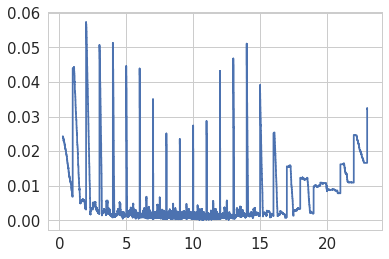

In [60]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very interesting feature !  
It looks like ip addresses that use same device in average between 5 and 15 download much less.

### ip_os_avg_minute

In [61]:
feature = 'ip_os_avg_minute'

In [62]:
PDF = train_sample.select('is_attributed', feature).toPandas()

In [63]:
PDF.head()

,is_attributed,ip_os_avg_minute
0,0,30.62
1,0,30.62
2,0,30.62
3,0,30.62
4,0,30.62


In [64]:
PDF_sorted = PDF.sort_values(by=feature)

In [65]:
PDF_sorted['roll'] = PDF_sorted.is_attributed.rolling(window=10000).mean()

In [66]:
PDF_sorted.head()

,is_attributed,ip_os_avg_minute,roll
7479340,0,0.0,NaN
2934822,0,0.0,NaN
1318613,0,0.0,NaN
8823352,0,0.0,NaN
344954,1,0.0,NaN


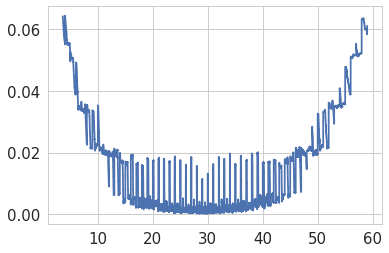

In [68]:
plt.plot(PDF_sorted[feature], PDF_sorted.roll)

Very strong feature !  
It looks like ip addresses that use same os in average at the half of a minute download much less.  